# Gapminder EDA and Model Experimentation
# Part 1: Regression analysis of Gapminder data
Read in the data.

In [4]:
import pandas as pd
gap_data = pd.read_csv("mirror/08_gap-every-five-years.tsv", sep='\t')
gap_data.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


## Plot Life Expectancy Across Time

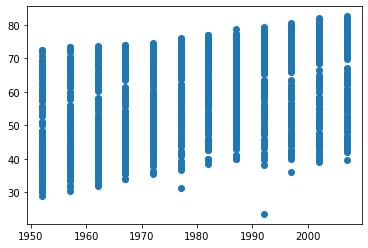

In [9]:
import matplotlib.pyplot as plt
plt.scatter(gap_data['year'], gap_data['lifeExp'])
plt.show()

The average life expectancy appears to be increasing over time. This trend also does appear to be linear. However, the distributions of life expectancies across countries for each year are quite spread out.

Look at violin plot:

Partition data by year.

In [15]:
years = pd.unique(gap_data['year'])
life_exp_per_year = []
for year in years:
    sub = gap_data[gap_data['year'] == year]
    life_exp_per_year.append(sub['lifeExp'])

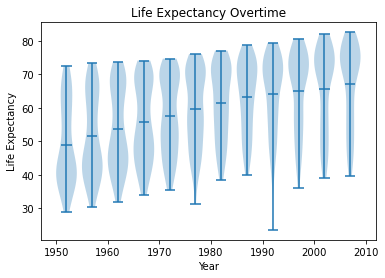

In [17]:
fig, ax = plt.subplots()

ax.violinplot(life_exp_per_year,years,widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy")
ax.set_title("Life Expectancy Overtime")
plt.show()

In [241]:
years

array([1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002,
       2007])

The distributions of life expectancies across countries for each year appear to be more right-skewed for years before 1977, and more left-skewed for years 1977 and onwards. The distributions for the years 1962-72 appear somewhat bimodal. None of the distributions appear very symmetric.

## Linear Regression Model

I would reject the null hypothesis of no relationship between life expectancy and year because the average life expectancy does appear to be increasing overtime. The linear regression model assumes that the data points are from independent, identical distributions and that the residuals follow a Gaussian distribution with a mean of zero. However, a violin plot of residuals would most likely display skewed distributions for each year because the original violin plot displayed skewed distributions, so the distribution of distances from the prediction would also likely be skewed.

In [20]:
import numpy as np
model = np.polyfit(gap_data['year'], gap_data['lifeExp'], 1)
reg_coef = np.poly1d(model)
reg_coef

poly1d([ 3.25903828e-01, -5.85652187e+02])

### Life Expectancy = 0.326*(year) - 585.65

In [250]:
import statsmodels.formula.api as smf

res = smf.ols(formula='lifeExp ~ year', data=gap_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                lifeExp   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     398.6
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           7.55e-80
Time:                        22:37:35   Log-Likelihood:                -6597.9
No. Observations:                1704   AIC:                         1.320e+04
Df Residuals:                    1702   BIC:                         1.321e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -585.6522     32.314    -18.124      0.0

On average, the global life expectancy is expected to increase by about 0.326 years each year

Look at r (correlation coefficient).

In [26]:
from sklearn.metrics import r2_score
import math
R2 = r2_score(gap_data['lifeExp'], reg_coef(gap_data['year']))
math.sqrt(R2)

0.4356112240540734

With a correlation coefficient of 0.4356, the strength of the correlation is moderate, so we can reject the null hypothesis.

Calculate the residuals for each year.

In [ ]:
for index in range(len(life_exp_per_year)):
    pred = reg_coef(years[index])
    life_exp_per_year[index] -= pred

Make violin plot of residuals for each year.

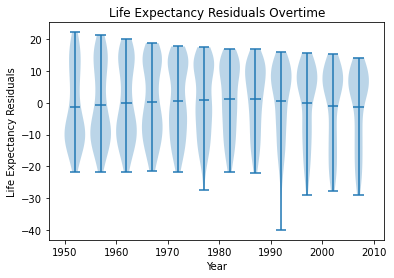

In [37]:
fig, ax = plt.subplots()

ax.violinplot(life_exp_per_year,years,widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy Residuals")
ax.set_title("Life Expectancy Residuals Overtime")
plt.show()

The violin plot of residuals did meet my expectations, in that most of the distributions of residuals for each year appear skewed because the original distributions of the life expectancies for each year were also skewed.

Add residuals column to the data.

In [48]:
residuals = []
for index in range(len(life_exp_per_year)):
    residuals += list(life_exp_per_year[index])
gap_data['residuals'] = residuals
gap_data.head()

,country,continent,year,lifeExp,pop,gdpPercap,residuals
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,-21.711084
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,4.717916
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,-7.435084
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,-20.497084
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,11.972916


Boxplot of model residuals vs continent.

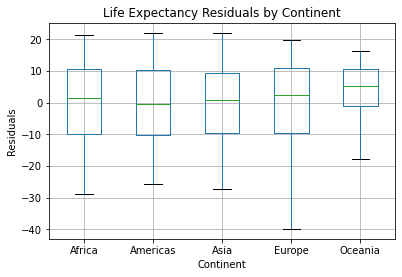

In [52]:
gap_data.boxplot(column='residuals', by='continent')
plt.suptitle('')
plt.title('Life Expectancy Residuals by Continent')
plt.xlabel('Continent')
plt.ylabel('Residuals')
plt.show()

The residuals appear to be mostly centered around zero for every continent except Oceania, which has higher residuals on average. It may be necessary to first partition by continent and then conduct a separate regression analysis for each continent because there does appear to be a dependence between residuals and continent. Specifically, the continent also influences the life expectancy in addition to the year. This may be because certain continents are on average wealthier than others and as a result have less crime and better access to healthcare, nutrition, and education which influences their life expectancy.

Scatter plot with regression line for each continent.

Africa:  
0.2895 x - 524.3
Americas:  
0.3677 x - 663.1
Asia:  
0.4531 x - 836.9
Europe:  
0.2219 x - 367.4
Oceania:  
0.2103 x - 341.9


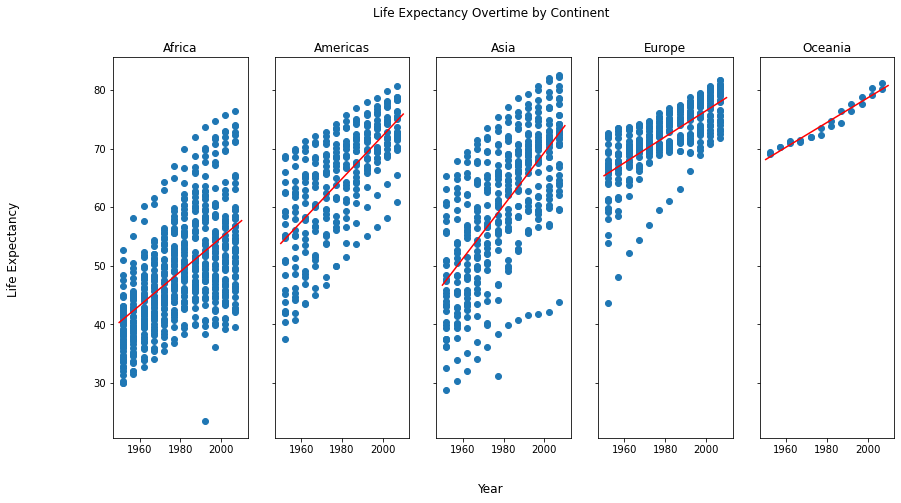

In [240]:
fig, axs = plt.subplots(1, 5, figsize=(14, 7), sharey=True)

fig.suptitle('Life Expectancy Overtime by Continent')
fig.supxlabel('Year')
fig.supylabel('Life Expectancy')

index = 0

for continent in ['Africa','Americas','Asia','Europe','Oceania']:
    sub_df = gap_data[gap_data['continent'] == continent]
    axs[index].scatter(sub_df['year'], sub_df['lifeExp'])
    axs[index].set_title(continent)
    z = np.polyfit(sub_df['year'], sub_df['lifeExp'], 1)
    p = np.poly1d(z)
    print(continent + ': ' + str(p))
    xp = np.linspace(1950, 2010, 100)
    axs[index].plot(xp, p(xp), color='red')
    index += 1

plt.show()

The regression model should include an interaction term for continent and year because the slopes and intercepts of the regression lines appear to be significantly different for each continent. There is a clear relationship between each continent and the life expectancy, because the variance in life expectancy cannot be explained by just the year. Thus, from the previous plot, the variance in life expectancy can be further explained by the inclusion of continent as well.

## Generalized Linear Model (GLM)

Assuming that the life expectancies for each continent follow a Gaussian distribution, fit a GLM to the data with interactions between continents and year.

In [68]:
import statsmodels.formula.api as smf

res1 = smf.glm(formula='lifeExp ~ continent + year + continent*year', data=gap_data[['continent','year','lifeExp']]).fit()

print(res1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                lifeExp   No. Observations:                 1704
Model:                            GLM   Df Residuals:                     1694
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          51.547
Method:                          IRLS   Log-Likelihood:                -5771.9
Date:                Thu, 24 Nov 2022   Deviance:                       87320.
Time:                        15:42:17   Pearson chi2:                 8.73e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8936
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The parameters in the model are all significantly different from zero, except for Oceania and the interaction between Oceania and year because these two parameters have high p-values (using a threshold of alpha = 0.05). The parameters for Africa were not shown because the model uses Africa as the baseline (as seen from the 9 degrees of freedom when the model has 10 variables/interactions).

On average, life expectancy is expected to increase each year by 0.29 years for Africa, (0.29 + 0.08 = 0.37) years for the Americas, (0.29 + 0.16 = 0.45) years for Asia, (0.29 - 0.07 = 0.22) years for Europe and (0.29 - 0.08 = 0.21) years for Oceania. However, the prediction for Oceania may not be very accurate because of the high p-values associated with its coefficients.

Add response residuals column to the data.

In [75]:
gap_data['glm_residuals'] = res1.resid_response
gap_data.head()

,country,continent,year,lifeExp,pop,gdpPercap,residuals,glm_residuals
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,-21.711084,-18.803037
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,4.717916,-19.537649
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,-7.435084,-20.138261
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,-20.497084,-20.380873
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,11.972916,-20.578485


Create new vector with separate vectors for each year.

In [85]:
glm_res = []
for year in years:
    sub = gap_data[gap_data['year'] == year]
    glm_res.append(sub['glm_residuals'])

Create a violin plot of GLM residuals for each year.

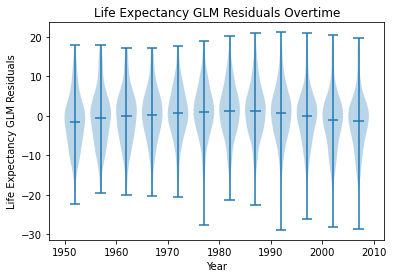

In [89]:
fig, ax = plt.subplots()

ax.violinplot(glm_res,years,widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy GLM Residuals")
ax.set_title("Life Expectancy GLM Residuals Overtime")
plt.show()

The generalized linear model assumed that the life expectancies for each continent in each year would be normally distributed. Here, the residuals for all the continents for each year do appear to mostly follow a normal distribution.